<a href="https://colab.research.google.com/github/Zafar-Lab/scDREAMER/blob/main/2109_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
import random
import numpy as np
import tensorflow as tf2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

2023-09-25 16:32:16.900683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 16:32:17.581215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:

np.random.seed(0)
tf.set_random_seed(0)
random.seed(0)
tf2.random.set_seed(0)
tf2.keras.utils.set_random_seed(0)


In [3]:
import warnings
warnings.filterwarnings('ignore')
"""
!pip install -U scipy==1.5.0
!pip install scanpy==1.8.2
!pip install -U scikit-learn
"""

'\n!pip install -U scipy==1.5.0\n!pip install scanpy==1.8.2\n!pip install -U scikit-learn\n'

Building model

In [4]:


name = "Immune_Human"

"""
NOTE:
Run setting as follows:
0: Supervised setting
10: 10 percent missing labels data
20: 20 percent missing labels data
50: 50 percent missing labels data
"""
run_setting = 0

In [5]:
"""

0: Supervised setting
10: 10% missing labels
20: 20% missing labels
50: 50% missing labels

"""

path = "/home/ajita/Documents/data_integration/"

data_path = {
    
"Immune_Human" : {0: path + "Immune/Immune_ALL_human.h5ad",
                  10: path + "Immune/Immune_Human_NA_0.1.h5ad",
                  20: path + "Immune/Immune_Human_NA_0.2.h5ad",
                  50: path + "Immune/Immune_Human_NA_0.5.h5ad"
                 },
    
"Human_Mouse" : {
                0: path + "hum_mou/hcl_mca_merged.h5ad"},
    
"Human_Retina" : {
                0: path + "Human_Retina/Human_Retina.h5ad"},
    
"Lung" : { 0: path + "Lung/Lung_atlas_public.h5ad",
          10: path + "Lung/Lung_NA_0.1.h5ad",
          20: path + "Lung/Lung_NA_0.2.h5ad",
          50: path + "Lung/Lung_NA_0.5.h5ad"
         },
    
"Healthy_Heart" : {
        0: path + "Healthy_Heart/Healthy_human_heart_adata.h5ad",
        20: path + "Healthy_Heart/Healthy_human_heart_adata_NA_0.2.h5ad",
        50: path + "Healthy_Heart/Healthy_human_heart_adata_NA_0.5.h5ad"}
}


batch_key_dict = {'Immune_Human' : 'batch',
                 'Lung' : 'batch',
                 'Pancreas' : 'tech',
                 'Human_Mouse' : 'batch',
                 'Human_Retina': "Batch",
                 "Healthy_Heart" : "sampleID"
                 
                }

cell_type_key_dict = {
    
"Immune_Human" : {0: "final_annotation", 10: "final_annotation_NA",
                  20: "final_annotation_NA", 50: "final_annotation_NA"
                 },
    
"Human_Mouse" : {
                0: "celltype"},
    
"Human_Retina" : {
                0: "Subcluster"},
    
"Lung" : { 0: "cell_type",
          10: "cell_type_NA",
          20: "cell_type_NA",
          50: "cell_type_NA"
         },
    
"Healthy_Heart" : {
        0: "celltype",
        20: "celltype_NA",
        50: "celltype_NA"},
    
"Human_Mouse" : {
     0: "celltype"
    }    
}
 
shuffle_type_dict = {
"Immune_Human" : {0: 1, 10: 2, 20: 2, 50: 2 },    
"Human_Retina" : { 0: 1},
"Lung" : { 0: 1,10: 2, 20: 2, 50: 2}, 
"Healthy_Heart" : {0: 1, 20: 1,50: 1},    
"Human_Mouse" : {0: 1}}

lr = {"lr_ae" : 0.0002, "lr_dis": 0.0007, "lr_bc": 0.0007}
lr_big_data = {"lr_ae" : 0.0002, "lr_dis": 0.00001, "lr_bc": 0.0007}

learning_rate = {
"Immune_Human" : {0: lr, 10: lr, 20: lr, 50: lr },    
"Human_Retina" : { 0: lr},
"Lung" : { 0: lr,10: lr, 20: lr, 50: lr}, 
"Healthy_Heart" : {0: lr_big_data, 20: lr_big_data, 50: lr_big_data},    
"Human_Mouse" : {0: {"lr_ae" : 0.00005, "lr_dis": 0.00001, "lr_bc": 0.0007}}}


# big datasets: 20 dimensions
latent_dim = {
                'Immune_Human' : 10,
                 'Lung' : 10,
                 'Pancreas' : 10,
                 'Human_Mouse' : 20,
                 'Human_Retina': 10,
                 "Healthy_Heart" : 20
    
            }

BS = {
"Immune_Human" : {0: 256, 10: 128, 20: 128, 50: 128 },    
"Human_Retina" : { 0: 256},
"Lung" : { 0: 256,10: 128, 20: 128, 50: 128}, 
"Healthy_Heart" : {0: 128, 20: 128,50: 128},    
"Human_Mouse" : {0: 128}}


epoch_dict = {
    'Immune_Human' : 300,
     'Lung' : 300,
     'Human_Mouse' : 300,
     'Human_Retina': 300,
     "Healthy_Heart" : 300
}

plot_cell_type_dict = {
                    "Healthy_Heart" : "celltype",
                    'Immune_Human' : 'final_annotation', 
                 'Lung' : 'cell_type',
                 'Pancreas' : 'celltype',
                 'Human_Mouse' : "celltype",
                 "Human_Retina":"Subcluster"
                    } 

"""
Below variable takes care of sparse matrix
If 1: pd.DataFrame.sparse.from_spmatrix(Ann.X) is used
If 0: pd.DataFrame(Ann.X)

By default 0, unless scarcity not handled by basis pandas operation
"""

sparseIP= {
        "Healthy_Heart" : 1,
    'Immune_Human' : 0, 
     'Lung' : 1,
     'Pancreas' : 0,
     'Human_Mouse' : 1,
     "Human_Retina": 0
}

2023-09-25 16:32:20.380508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5367 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:d8:00.0, compute capability: 7.5


Loading dataset
Preprocessing...
here [2 4 1 ... 1 2 2]
Shape self.data_train: (33506, 2000)
Shape self.data_test: (33506, 2000)
encoder input shape  Tensor("concat:0", shape=(?, 2010), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
decoder input shape  Tensor("concat_2:0", shape=(?, 20), dtype=float32)
inferred check Tensor("Max:0", shape=(), dtype=float32)
entering in for loop 1   512  -- > 256
KL gaussian z Tensor("mul_13:0", shape=(?,), dtype=float32)
KL gaussian l Tensor("mul_12:0", shape=(?,), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cluster DRA on DataSet /home/ajita/Documents/data_integration/Immune/Immune_ALL_human.h5ad ... 


2023-09-25 16:32:36.745832: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Epoch : [0] ,  a_loss = 447.2831, d_loss: -0.0166 , db_loss: 2.0159
Epoch : [1] ,  a_loss = 440.3687, d_loss: -0.2286 , db_loss: 1.6726
Epoch : [2] ,  a_loss = 418.7642, d_loss: -0.2528 , db_loss: 1.5301
Epoch : [3] ,  a_loss = 422.3308, d_loss: -0.3176 , db_loss: 1.4365
Epoch : [4] ,  a_loss = 409.5872, d_loss: -1.2763 , db_loss: 1.5439
Epoch : [5] ,  a_loss = 405.9718, d_loss: -1.6753 , db_loss: 1.5118
Epoch : [6] ,  a_loss = 409.4523, d_loss: -1.7804 , db_loss: 1.5908
Epoch : [7] ,  a_loss = 404.2825, d_loss: -0.6542 , db_loss: 1.5755
Epoch : [8] ,  a_loss = 414.4922, d_loss: -0.3211 , db_loss: 1.4694
Epoch : [9] ,  a_loss = 398.7779, d_loss: -0.1814 , db_loss: 1.5102
Epoch : [10] ,  a_loss = 406.2830, d_loss: -1.2892 , db_loss: 1.5625
Epoch : [11] ,  a_loss = 405.4329, d_loss: -0.7041 , db_loss: 1.5352
Epoch : [12] ,  a_loss = 396.8889, d_loss: -0.3090 , db_loss: 1.5336
Epoch : [13] ,  a_loss = 392.9378, d_loss: -0.4251 , db_loss: 1.6367
Epoch : [14] ,  a_loss = 378.2116, d_loss: -

Epoch : [119] ,  a_loss = 337.9682, d_loss: -0.0162 , db_loss: 1.7003
Epoch : [120] ,  a_loss = 335.4896, d_loss: -0.0123 , db_loss: 1.7179
Epoch : [121] ,  a_loss = 340.5697, d_loss: -0.0094 , db_loss: 1.5684
Epoch : [122] ,  a_loss = 334.1050, d_loss: -0.0087 , db_loss: 1.6718
Epoch : [123] ,  a_loss = 333.3666, d_loss: -0.0069 , db_loss: 1.6903
Epoch : [124] ,  a_loss = 337.9978, d_loss: -0.0064 , db_loss: 1.5696
Epoch : [125] ,  a_loss = 339.5130, d_loss: -0.0062 , db_loss: 1.6191
Epoch : [126] ,  a_loss = 339.7994, d_loss: -0.0040 , db_loss: 1.7358
Epoch : [127] ,  a_loss = 342.4346, d_loss: -0.0050 , db_loss: 1.5507
Epoch : [128] ,  a_loss = 331.6218, d_loss: -0.0045 , db_loss: 1.7026
Epoch : [129] ,  a_loss = 337.1452, d_loss: -0.0054 , db_loss: 1.6548
Epoch : [130] ,  a_loss = 337.4349, d_loss: -0.0039 , db_loss: 1.7239
Epoch : [131] ,  a_loss = 335.1758, d_loss: -0.0035 , db_loss: 1.6670
Epoch : [132] ,  a_loss = 336.4121, d_loss: -0.0033 , db_loss: 1.6514
Epoch : [133] ,  a_l

Epoch : [237] ,  a_loss = 325.3782, d_loss: -1.8470 , db_loss: 1.7894
Epoch : [238] ,  a_loss = 329.3347, d_loss: -1.6092 , db_loss: 1.6015
Epoch : [239] ,  a_loss = 332.6536, d_loss: -1.1550 , db_loss: 1.6128
Epoch : [240] ,  a_loss = 332.5920, d_loss: -1.2048 , db_loss: 1.7092
Epoch : [241] ,  a_loss = 320.8654, d_loss: -1.1287 , db_loss: 1.8276
Epoch : [242] ,  a_loss = 335.1607, d_loss: -1.4980 , db_loss: 1.6625
Epoch : [243] ,  a_loss = 330.2157, d_loss: -1.3539 , db_loss: 1.6368
Epoch : [244] ,  a_loss = 332.0506, d_loss: -1.0079 , db_loss: 1.6277
Epoch : [245] ,  a_loss = 332.2034, d_loss: -1.2835 , db_loss: 1.6717
Epoch : [246] ,  a_loss = 323.5639, d_loss: -1.5559 , db_loss: 1.6704
Epoch : [247] ,  a_loss = 326.9017, d_loss: -1.6416 , db_loss: 1.7944
Epoch : [248] ,  a_loss = 327.5092, d_loss: -1.5812 , db_loss: 1.7335
Epoch : [249] ,  a_loss = 330.3425, d_loss: -1.9126 , db_loss: 1.6241
Epoch : [250] ,  a_loss = 333.9794, d_loss: -1.6605 , db_loss: 1.5766
Epoch : [251] ,  a_l

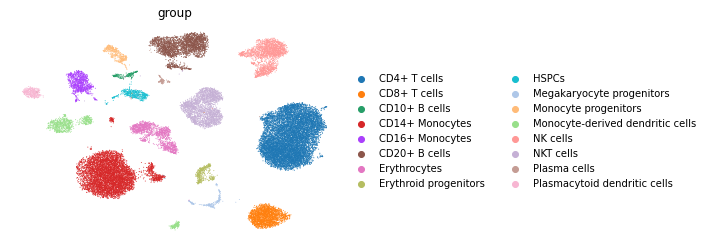

None


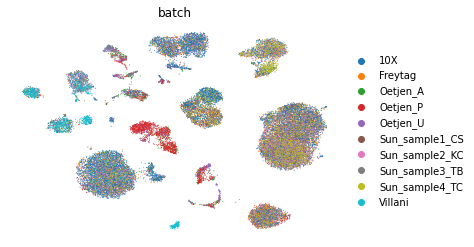

None
Computing NMI ...
Done !
NMI = 0.8798515327528164


In [6]:

# Add avg of losses

import src.model as model


run_config = tf.ConfigProto()

run_config.gpu_options.per_process_gpu_memory_fraction = 0.333
run_config.gpu_options.allow_growth = True

with tf.Session(config = run_config) as sess:

    dreamer = model.scDREAMER(
        sess,
        epoch = epoch_dict[name],
        dataset_name = data_path[name][run_setting],
        batch = batch_key_dict[name],
        cell_type = cell_type_key_dict[name][run_setting],
        plot_cell_type = plot_cell_type_dict[name],
        name = name,
        lr_ae = learning_rate[name][run_setting]['lr_ae'],
        lr_dis = learning_rate[name][run_setting]['lr_dis'],
        lr_bc = learning_rate[name][run_setting]['lr_bc'],
        batch_size = BS[name][run_setting],
        z_dim = latent_dim[name],
        shuffle_type = shuffle_type_dict[name][run_setting],
        sparseIP = sparseIP[name]
        )

    dreamer.train_cluster()

    